In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sphere import Component, MultiComponentSystem

# `MultiComponentSystem` usage for two component condensation

This notebook uses the `MultiComponentSystem` class to simulate two component condensation on a spherical particle in the kinetic regime.

### Create an instance of `Component`

Instances of `Component` are created to represent different condensable components. Thermodynamic properties need to be provided in the class constructor. Clausius-Clapeyron equation is used to extrapolate saturated vapor pressure from the reference point.

In [2]:
ARO_1_COMPONENT = Component(
    'ARO1',     # name
    5.7e-5,     # reference vapor pressure
    298,        # reference temperature
    156e3,      # enthalpy of vaporization
    150e-3,     # molar mass
    1200.0,     # condensed phase density
    0.01        # condensed phase surface tension
)

ARO_2_COMPONENT = Component(
    'ARO2',     # name
    1.6e-3,     # reference vapor pressure
    298,        # reference temperature
    156e3,      # enthalpy of vaporization
    150e-3,     # molar mass
    1100.0,     # condensed phase density
    0.01        # condensed phase surface tension
)

### Define a function that describes saturation ratio as a function of time

A function that returns vapor saturation ratio as a function of time is defined. The function should return an array of saturation ratios, each corresponding to a condensable component.

In [3]:
def xi_function(t: float) -> np.ndarray[float]:
    return np.array([
        0.2,   # saturation ratio of first component
        0.2    # saturation ratio of second component
    ])

### Create an instance of `MultiComponentSystem`

An instance of `MultiComponentSystem` is created by specifying the components and ambient conditions. Class constructor automatically determines the equilibrium liquid phase composition based on Raoult's law and defines the `condensed_phase_mole_counts_0` attribute, which is an array containing mole counts of each liquid phase component.

In [4]:
system = MultiComponentSystem(
    [
        ARO_1_COMPONENT,
        ARO_2_COMPONENT
    ],                  # the components
    xi_function,        # saturation ratio function
    14.0e-9,            # radius of the core
    1.0e-21,            # initial moles of condensate
    101_325.0,          # ambient (atmospheric) pressure
    298.0               # ambient temperature
)

### Solve the ODE

Integrate the ordinary differential equation that models vapor condensation on a sphere in the kinetic regime by using `scipy.integrate.solve_bvp` and the interface function `MultiComponentSystem.ode_function`.

In [5]:
duration = 30.0

sol = solve_ivp(
    system.ode_function,                    # reference to the function defining the ODE system
    [0, duration],                          # start and end time
    system.condensed_phase_mole_counts_0,   # initial conditions for condensed phase mole counts were initialized by the constructor
    t_eval=np.linspace(0, duration, 100),   # array of time points where the solution has to be evaluated
    method='LSODA'                          # use LSODA solver
)

### Plot the results

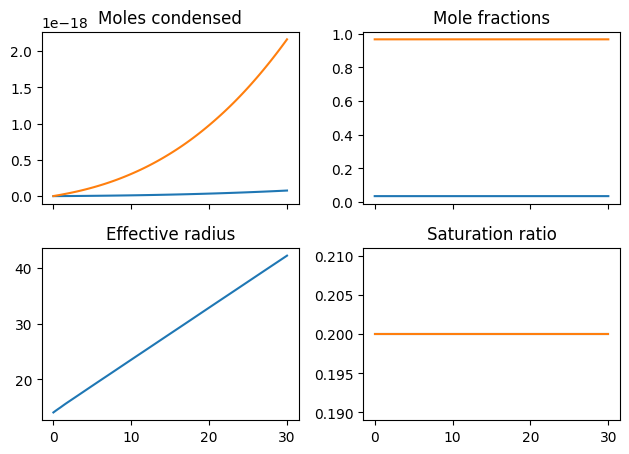

In [6]:
mole_fractions = sol.y / np.sum(sol.y, axis=0)

fig, axs = plt.subplots(2, 2, sharex=True)

axs[0, 0].set_title('Moles condensed')
axs[0, 0].plot(sol.t, sol.y[0, :])
axs[0, 0].plot(sol.t, sol.y[1, :])

axs[0, 1].set_title('Mole fractions')
axs[0, 1].plot(sol.t, mole_fractions[0, :])
axs[0, 1].plot(sol.t, mole_fractions[1, :])

axs[1, 0].set_title('Effective radius')
axs[1, 0].plot(sol.t, system.r_part(np.transpose(sol.y)) * 1e9)

axs[1, 1].set_title('Saturation ratio')
axs[1, 1].plot(sol.t, [xi_function(t) for t in sol.t])

plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

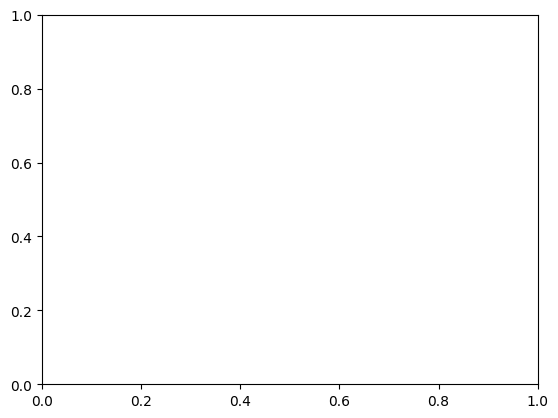

In [7]:
condensate_mole_counts = np.sum(sol.y, axis=0)

plt.plot(condensate_mole_counts, system.kappa_concave(np.transpose(sol.y)))